In [1]:
import sys
!{sys.executable} -m pip install gym
#!{sys.executable} -m pip install tensorflow

sys.path.insert(1, "../")

In [2]:

import importlib
from collections import defaultdict

import statistics
import matplotlib.pyplot as plt

import numpy as np
import math

import pandas as pd

import gym
from gym import spaces
import random

from copy import deepcopy

from planning.ValueIteration import ValueIteration as ValueIteration

from environment.TwoArmedBanditEnv import TwoArmedBandit

#from agent import AgentModel as ag

# Utilidade na diferença temporal

$$\Large TD =  R\left( s \right) + \gamma V\left( s' \right) - V\left( s \right)  $$

$$\Large V\left( s \right) = V\left( s \right) + \alpha \left[  u\left(  TD \right ) \right]$$

# Utilidade exponencial

$$\Large u\left ( x \right ) = sign(\lambda) e^{\lambda x }$$

# Utilidade Soft indicator

$$\Large u\left ( x \right ) = \frac{2x}{ 1+ e^{-\lambda x } }$$

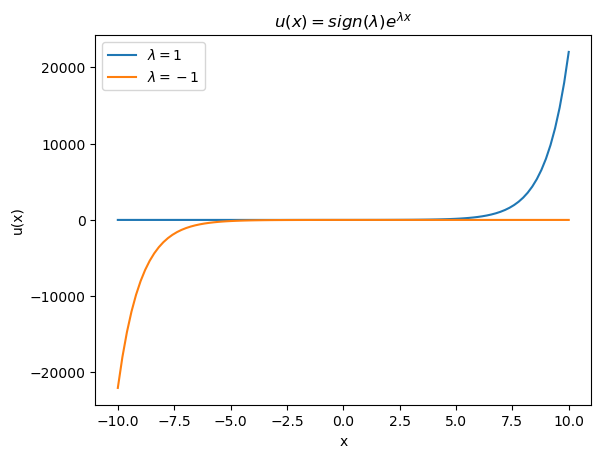

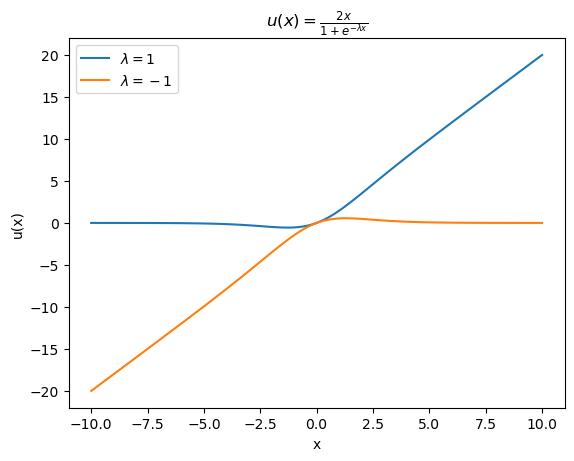

In [3]:
def utility_test(x, lamb):
    return np.sign(lamb) * np.exp(lamb * x)

def utility_test_soft(x, lamb):
    return (2*x)/(1 + np.exp(-lamb * x))

def utility_test_mih(x, lamb):
    result = []
    for i in x:
        if i>=0:
            result.append((1+lamb) * i)
        else:
            result.append((1-lamb) * i)
    return result

x = np.linspace(-10, 10, 100)


plt.plot(x, utility_test(x, 1), label=r'$\lambda = 1$')
plt.plot(x, utility_test(x, -1), label=r'$\lambda = -1$')
plt.legend()
plt.title(r'$u(x) = sign(\lambda) e^{\lambda x}$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

plt.plot(x, utility_test_soft(x, 1), label=r'$\lambda = 1$')
plt.plot(x, utility_test_soft(x, -1), label=r'$\lambda = -1$')
plt.legend()
plt.title(r'$u(x) = \frac{2x}{1 + e^{-\lambda x}} $')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()


#plt.plot(x, utility_test_mih(x, 1), label=r'$\lambda = 1$')
#plt.plot(x, utility_test_mih(x, -1), label=r'$\lambda = -1$')
#plt.legend()
#plt.title('u(x) = (1+k) x || (1-k) x')
#plt.xlabel('x')
#plt.ylabel('u(x)')
#plt.show()


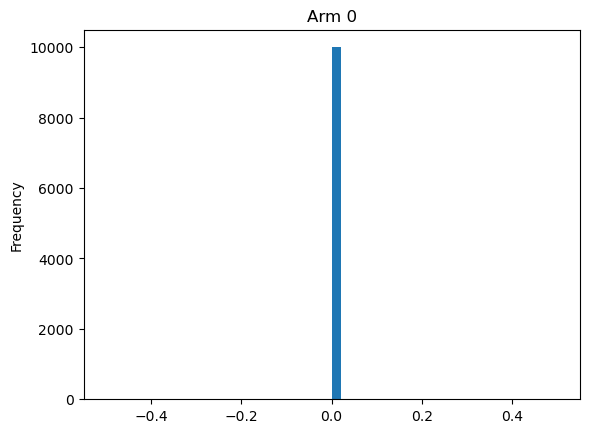

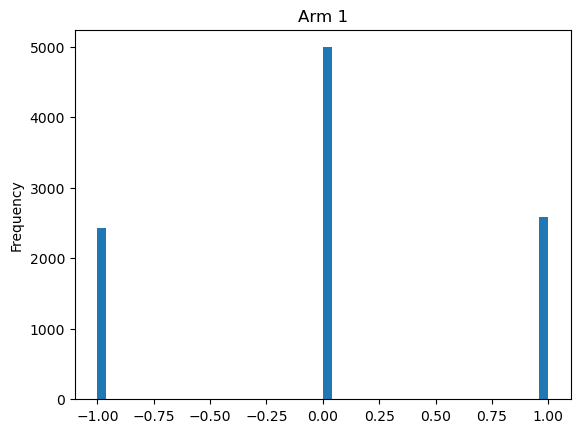

In [4]:
env = TwoArmedBandit(0,0)

arm_0 = []
arm_1 = []

for i in range(10_000):
    s_next, r, done, info = env.step(0)
    arm_0.append(r)
    env.reset()
    
    s_next, r, done, info = env.step(1)
    arm_1.append(r)
    env.reset()

plt.hist(arm_0, bins=50)
plt.gca().set(title='Arm 0', ylabel='Frequency');
plt.show()


plt.hist(arm_1, bins=50)
plt.gca().set(title='Arm 1', ylabel='Frequency');

# Testing on Value Iteration

In [7]:
lambs = [-5, -2, -0.5, -0.1, 0.1, 0.5, 2, 5]
gamma = 0.99
alpha = 0.1
    
def calculate_vi(t):
    env = TwoArmedBandit(0,0)

    results_vi = {}
    steps_vi = {}
    epsilon = 1e-8

    #for lamb in lambs:
    for lamb in lambs:
        print('LAMB {}'.format(lamb))

        results_vi[lamb] = np.zeros((31, 31))

        for i in range(0,31):
            arm_0_r = (-0.5+(i*(1/30)))
            for j in range(0,31):
                arm_1_mean = (-0.5+(j*(1/30)))

                env = TwoArmedBandit(arm_0_r,arm_1_mean)

                if t == 'Target':
                    policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_target(env, lamb, gamma, alpha)
                elif t == 'TD':
                    policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_td(env, lamb, gamma, alpha)
                elif t == 'Soft Indicator':
                    policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_soft_indicator(env, lamb, gamma, alpha)
                elif t == 'Mihatsch':
                    policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_mihatsch(env, lamb, gamma, alpha)
                
                steps_vi[lamb] = steps
                if policy[0] == 0:
                    results_vi[lamb][i][j] -= 100
                else:
                    results_vi[lamb][i][j] += 100

    print('DONE'.format(lamb))
    return results_vi, steps_vi


def print_results(results, reverse=False, shift=0):
    fig = plt.figure(figsize=(20, 10))
    columns = 4
    rows = 2

    i = 0

    lambs = results.keys()
    if reverse:
        lambs = list(reversed(sorted(results.keys())))

    for lamb in lambs:
    #for i in range(1, columns*rows +1):
        i+=1
       
        fig.add_subplot(rows, columns, i)
        plt.title(r'$\lambda$ {}'.format(lamb))
        plt.xlabel('Mean Arm 1')
        plt.ylabel('Reward Arm 0')
        plt.imshow(results[lamb], cmap='coolwarm', origin='lower',vmin=-100, vmax=100)
        #plt.colorbar()
        plt.xticks([0,15,30], [-0.5+shift,0+shift,0.5+shift])
        plt.yticks([0,15,30], [-0.5+shift,0+shift,0.5+shift])
        plt.plot([0,30],[0,30], linewidth=1, color='black')
    plt.show()

In [6]:
result_so, steps_so = calculate_vi('Soft Indicator')
#result_mi = calculate_vi('Mihatsch')
result_ta, steps_ta = calculate_vi('Target')
result_td, steps_td = calculate_vi('TD')


LAMB -5
LAMB -2
LAMB -0.5
LAMB -0.1
LAMB 0.1
LAMB 0.5
LAMB 2
LAMB 5
DONE
LAMB -5
LAMB -2
LAMB -0.5
LAMB -0.1
LAMB 0.1
LAMB 0.5
LAMB 2
LAMB 5
DONE
LAMB -5
LAMB -2
LAMB -0.5
LAMB -0.1
LAMB 0.1
LAMB 0.5
LAMB 2
LAMB 5
DONE


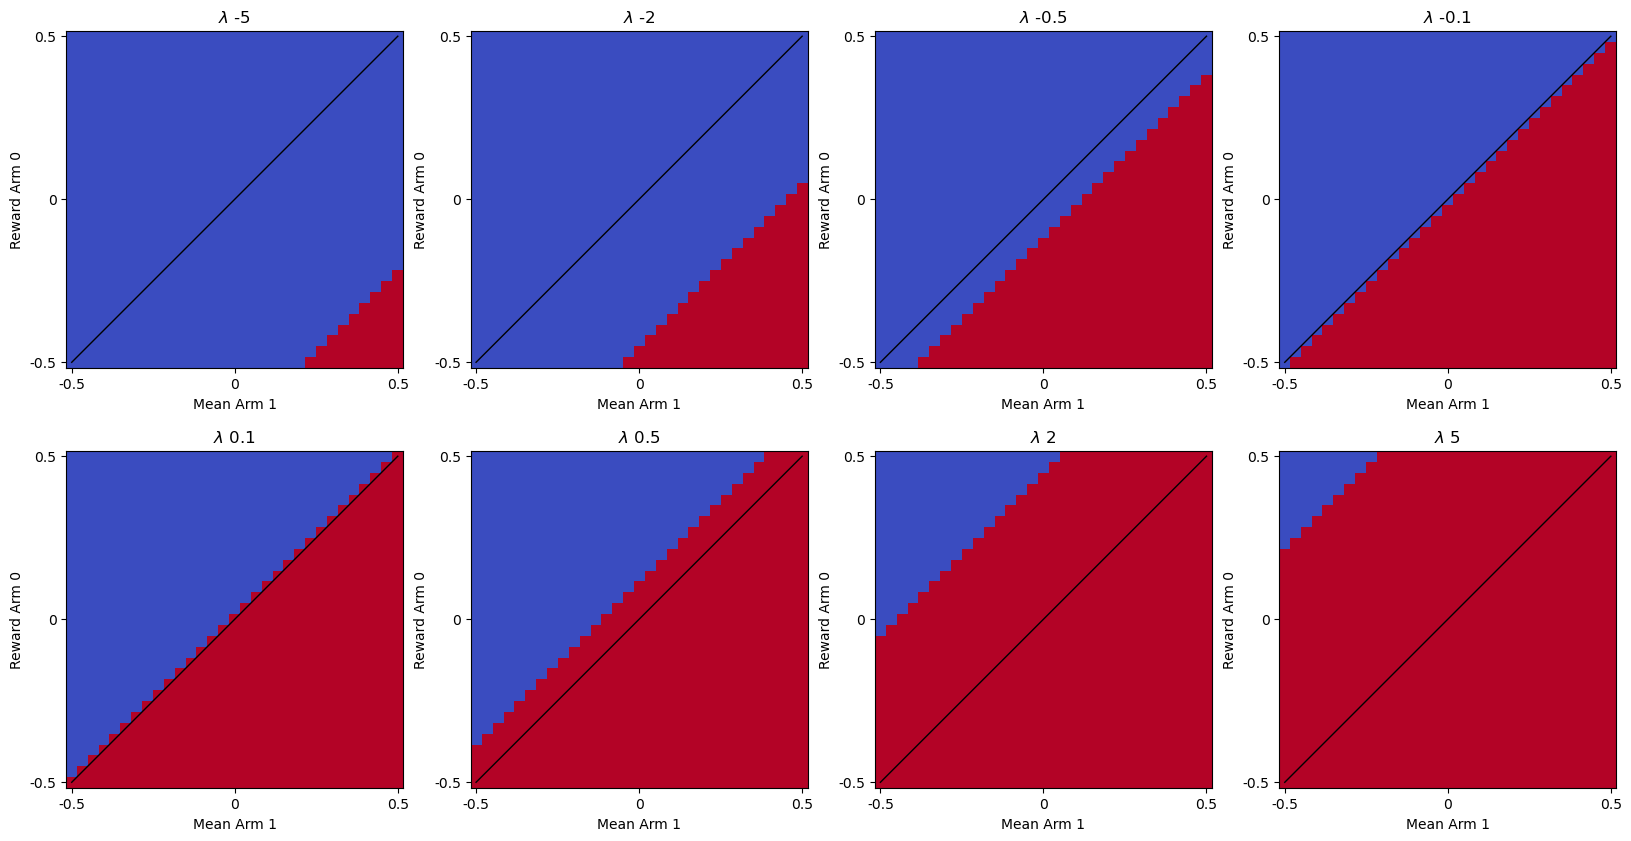

In [8]:
print_results(result_ta)

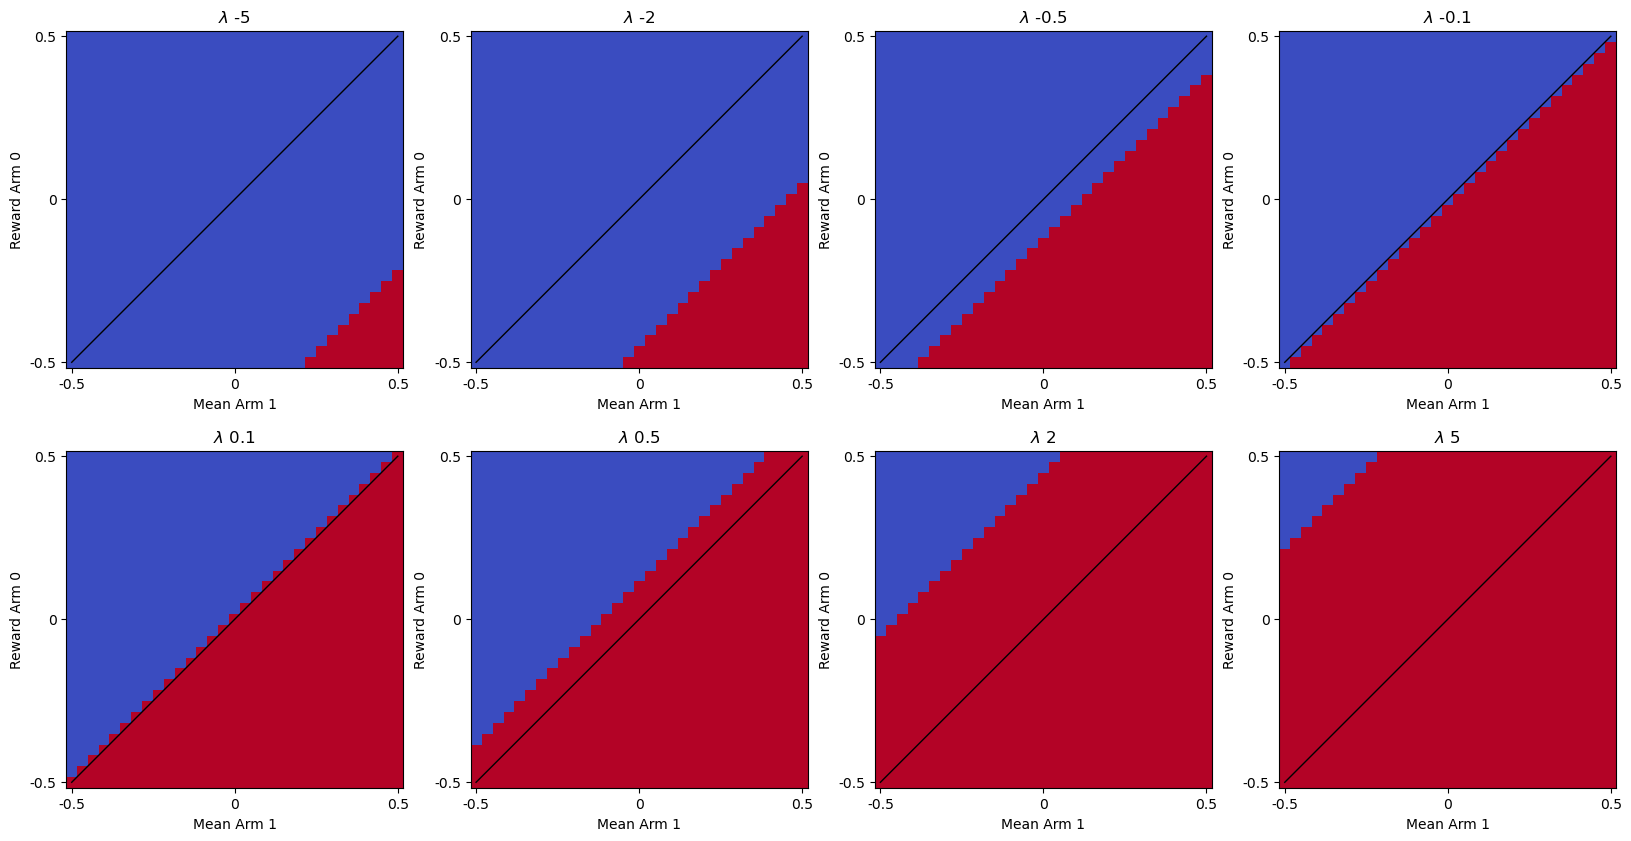

In [9]:
print_results(result_td)

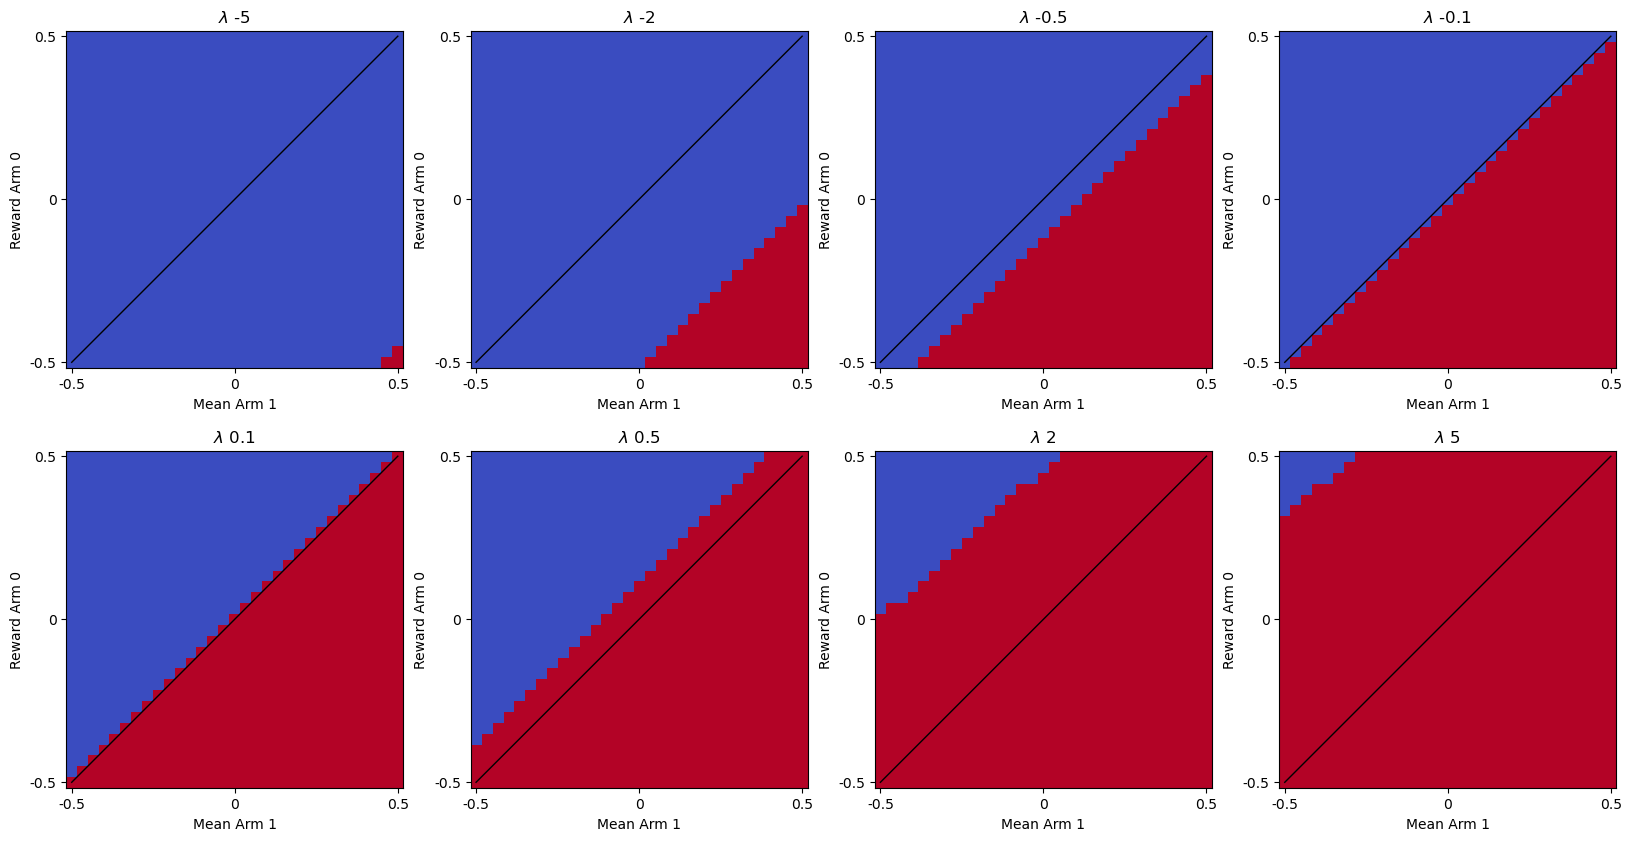

In [10]:
print_results(result_so)

In [11]:
def calculate_steps(t):
    env = TwoArmedBandit(0,0)

    v_s0 = {}
    steps_vi = {}
    epsilon = 1e-8

    for l in range(-15, 51, 1):
        lamb = l / 10

        if lamb == 0:
            print('skip 0')
            continue
        #print('LAMB {}'.format(lamb))

        if t == 'Target':
            policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_target(env, lamb, gamma, alpha)
        elif t == 'TD':
            policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_td(env, lamb, gamma, alpha)
        elif t == 'Soft Indicator':
            policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_soft_indicator(env, lamb, gamma, alpha)
        elif t == 'Mihatsch':
            policy, V, steps, updates, diffs, V_history, utilities = ValueIteration.run_mihatsch(env, lamb, gamma, alpha)

        steps_vi[lamb] = steps
        
        v_s0[lamb] = []
        for v in V_history:
            v_s0[lamb].append(v[0])
        

    print('DONE'.format(lamb))
    return v_s0, steps_vi


def plot_steps_converge(steps_ta, steps_td, steps_so):
    
    min_ta = []
    min_td = []
    min_so = []
    min_l = []
    
    max_ta = []
    max_td = []
    max_so = []
    max_l = []
    for l in steps_ta:
        if l < 0:
            min_ta.append(steps_ta[l])
            min_td.append(steps_td[l])
            min_so.append(steps_so[l])
            min_l.append(l)
            
        if l > 0:
            max_ta.append(steps_ta[l])
            max_td.append(steps_td[l])
            max_so.append(steps_so[l])
            max_l.append(l)
    
    plt.plot(min_l, min_td, label = 'TD', color='orange')
    plt.plot(max_l, max_td, label = 'TD', color='orange')
    
    plt.plot(min_l, min_ta, label = 'Target', color='blue')
    plt.plot(max_l, max_ta, label = 'Target', color='blue')
    
    plt.plot(min_l, min_so, label = 'Soft Indicator', color='green')
    plt.plot(max_l, max_so, label = 'Soft Indicator', color='green')

    plt.legend()

    plt.title(r'Steps to Converge'.format(alpha))
    plt.xlabel('Risk Factor')
    plt.ylabel('Steps')
    plt.show()


In [12]:
vso_so, steps_so = calculate_steps('Soft Indicator')
vso_ta, steps_ta = calculate_steps('Target')
vso_td, steps_td = calculate_steps('TD')


skip 0
DONE
skip 0
DONE
skip 0
DONE


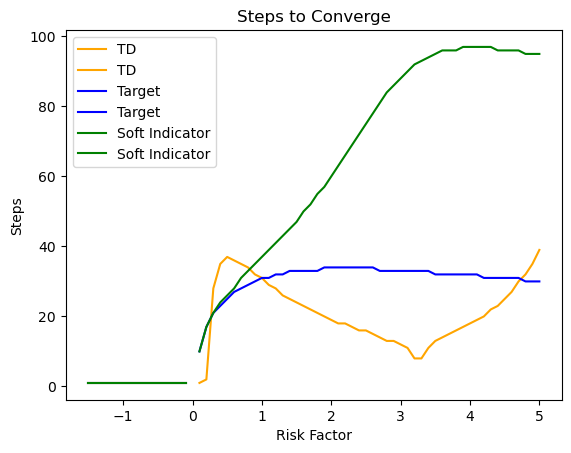

In [13]:
plot_steps_converge(steps_ta, steps_td, steps_so)

# Q Learning

In [36]:
result_ql_calc = pd.read_csv('../logs_two/ql2/4-result_alpha_0.1_calc.log',
                    sep='\t', 
                    names=['lamb', 'type', 'step',"i","j", "value"])

FileNotFoundError: [Errno 2] No such file or directory: '../logs_two/ql2/4-result_alpha_0.1_calc.log'

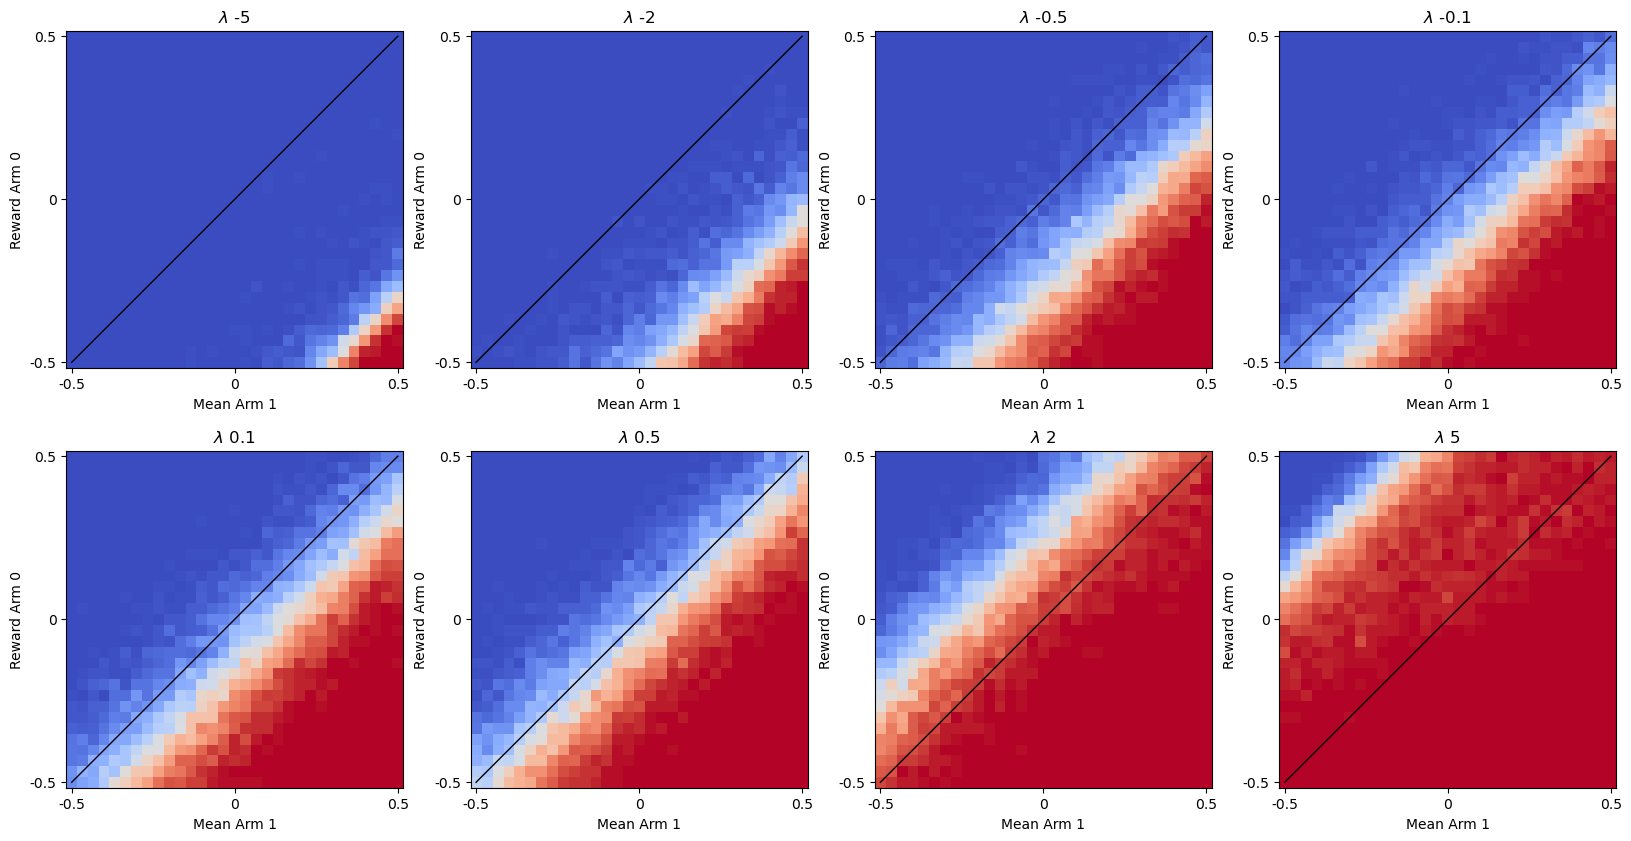

In [37]:
def print_results_df(df_ql, t):
    results_vi = {}

    df = df_ql.loc[(df_ql['type'] == t)].groupby(['lamb', 'i', 'j']).agg({'value': 'sum'}).reset_index()
    
    for lamb in lambs:
        results_vi[lamb] = np.zeros((31, 31))

        for i in range(0,31):
            for j in range(0,31):
                sum_i_j = df.loc[(df['lamb'] == lamb) & (df['i'] == i) & (df['j'] == j)]['value'].sum()
                results_vi[lamb][i][j] -= sum_i_j
                
    print_results(results_vi)
                
print_results_df(result_ql_calc, 'Target')

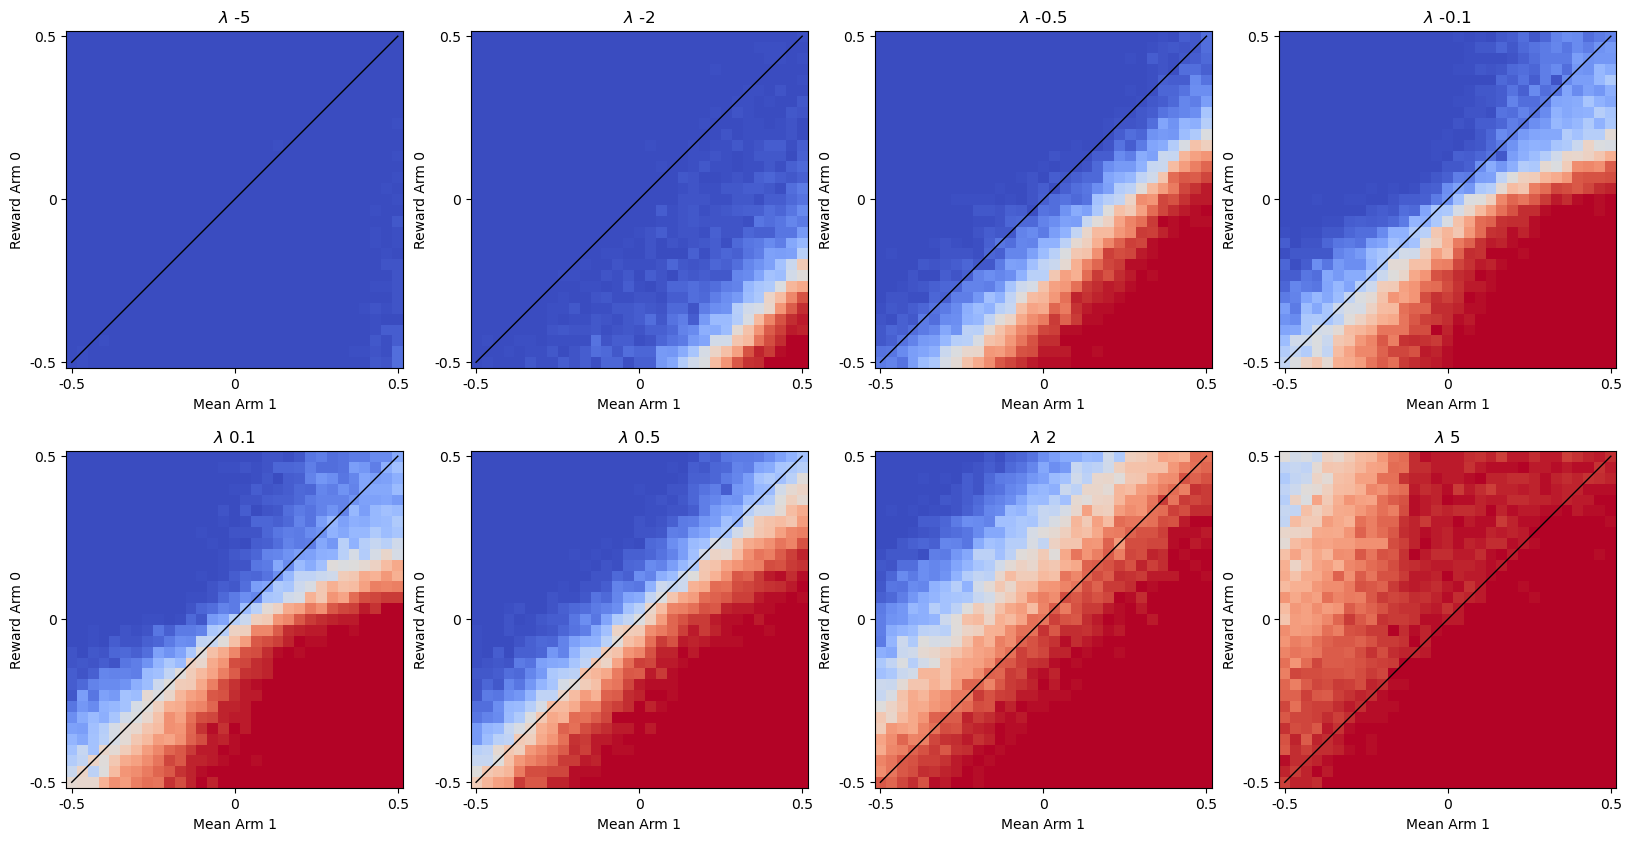

In [38]:
print_results_df(result_ql_calc, 'TD')

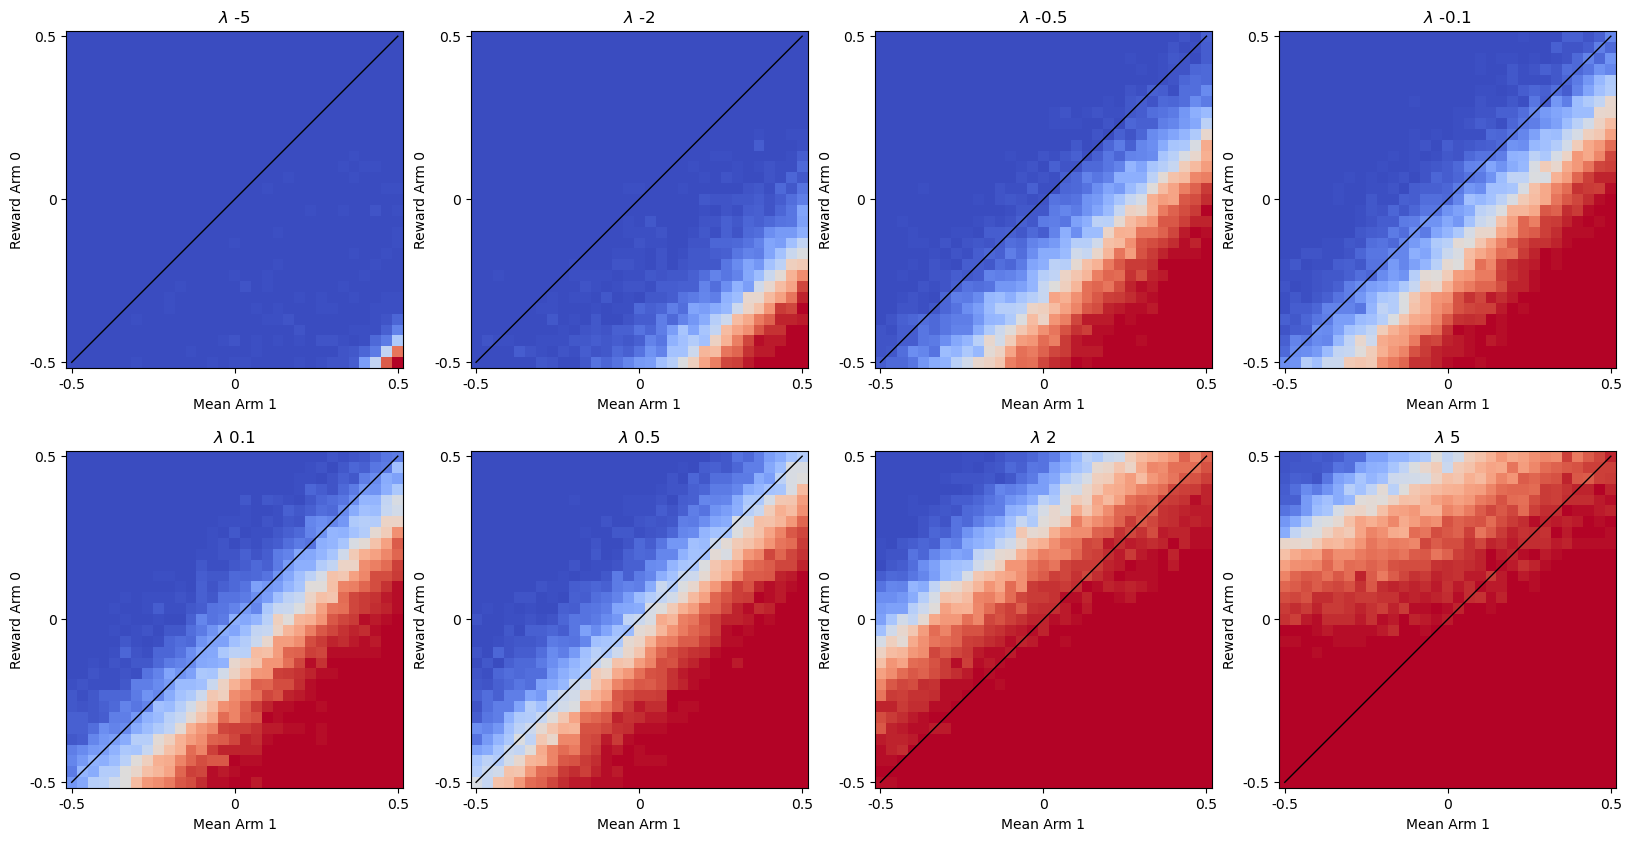

In [39]:
print_results_df(result_ql_calc, 'SI')

In [41]:


def print_results_alpha(results, reverse=False, shift=0):
    fig = plt.figure(figsize=(20, 16))
    columns = 4
    rows = 3

    i = 0

    types = results.keys()

    for t in types:
        alphas = results[t].keys()
        for alpha in alphas:
            i+=1

            fig.add_subplot(rows, columns, i)
            plt.title(r'{} - $\alpha$ {}'.format(t, alpha))
            plt.xlabel('Mean Arm 1')
            plt.ylabel('Reward Arm 0')
            plt.imshow(results[t][alpha], cmap='coolwarm', origin='lower',vmin=-100, vmax=100)
            #plt.colorbar()
            plt.xticks([0,15,30], [-0.5+shift,0+shift,0.5+shift])
            plt.yticks([0,15,30], [-0.5+shift,0+shift,0.5+shift])
            plt.plot([0,30],[0,30], linewidth=1, color='black')
    plt.show()
    
def print_results_alpha_df(df_ql):
    results_vi = {}

    df = df_ql.groupby(['type','alpha', 'i', 'j']).agg({'value': 'sum'}).reset_index()
    
    for t in ['Target', 'TD', 'SI']:
        results_vi[t] = {}
        for alpha in [0.2, 0.1, 0.05, 0.01]:
            results_vi[t][alpha] = np.zeros((31, 31))

            for i in range(0,31):
                for j in range(0,31):
                    sum_i_j = df.loc[(df['type'] == t) & (df['alpha'] == alpha) & (df['i'] == i) & (df['j'] == j)]['value'].sum()
                    results_vi[t][alpha][i][j] -= sum_i_j
                
    print_results_alpha(results_vi)


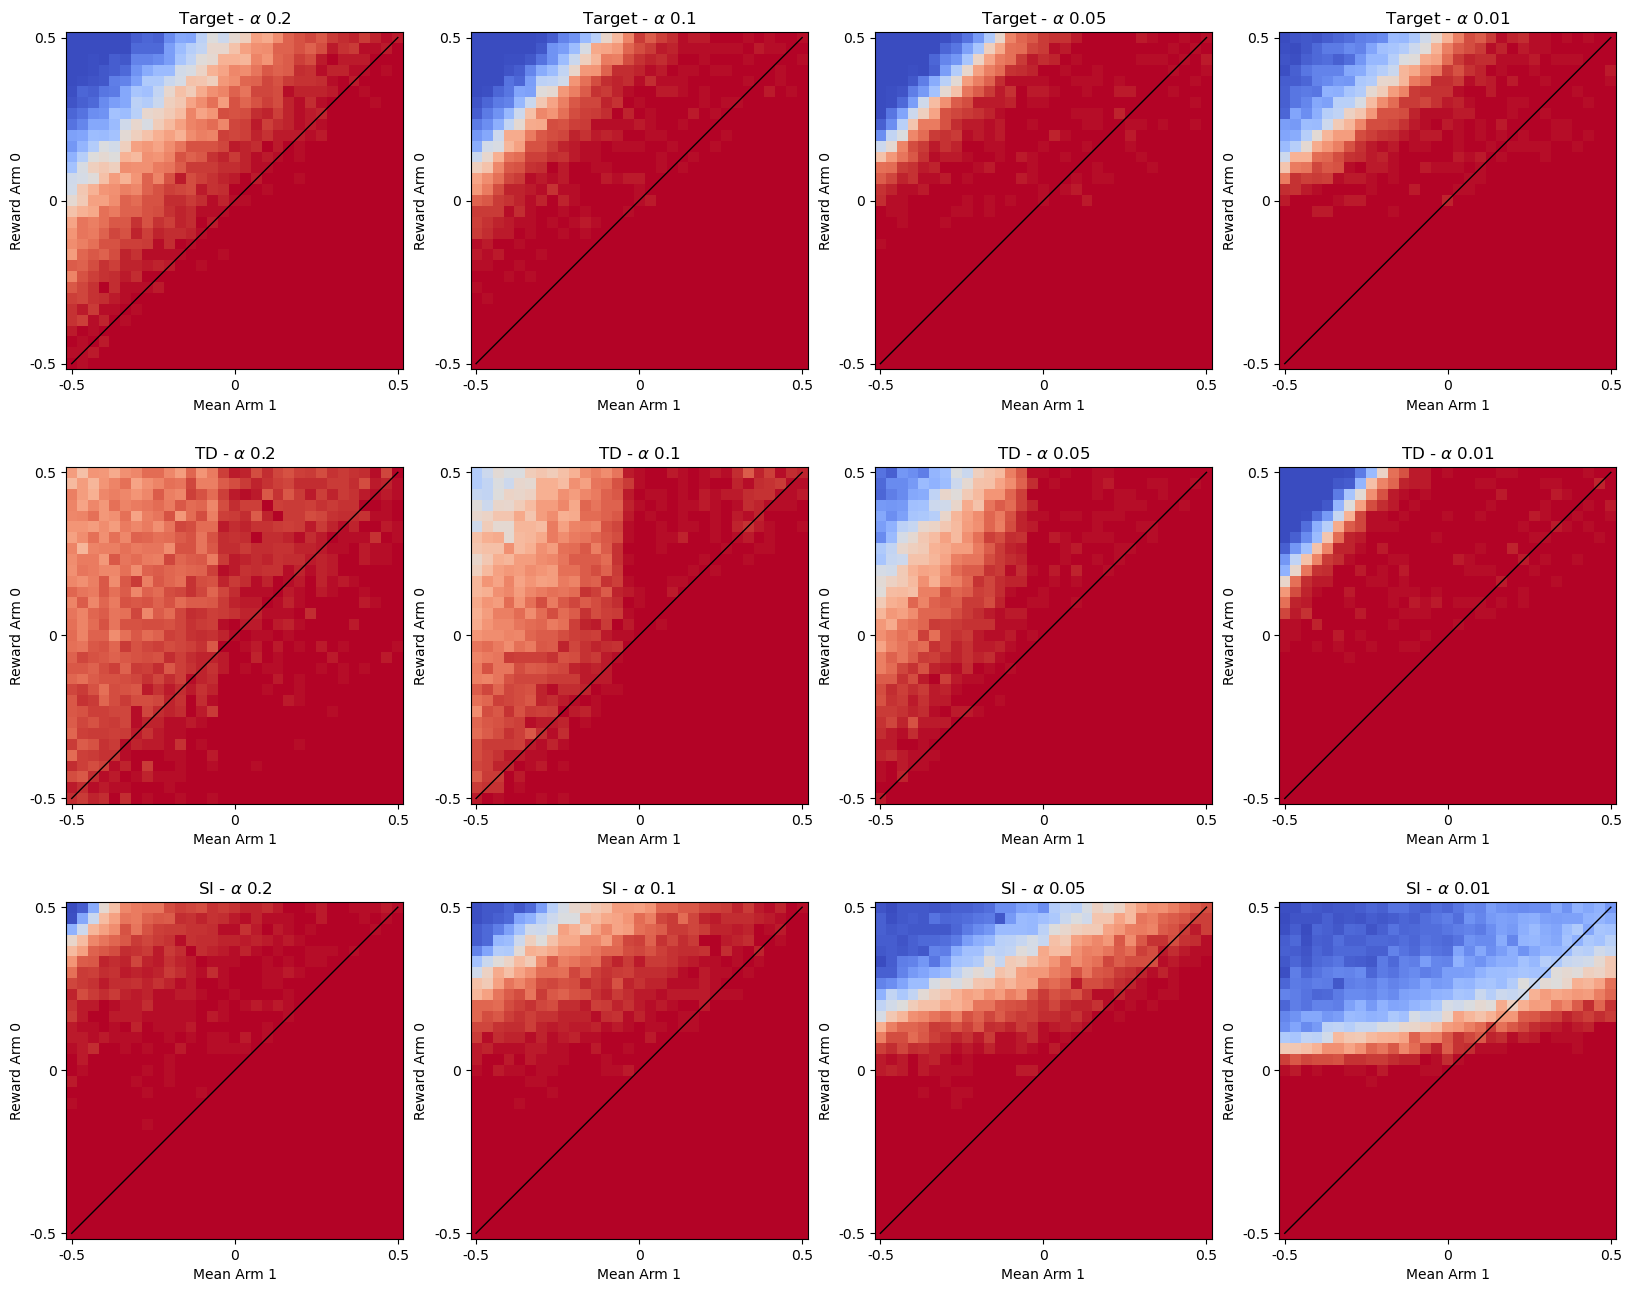

In [35]:
result_alpha_calc = pd.read_csv('../logs_two/ql2/4-result_alpha_var_calc.log',
                    sep='\t', 
                    names=['alpha', 'type', 'step',"i","j", "value"])

print_results_alpha_df(result_alpha_calc)

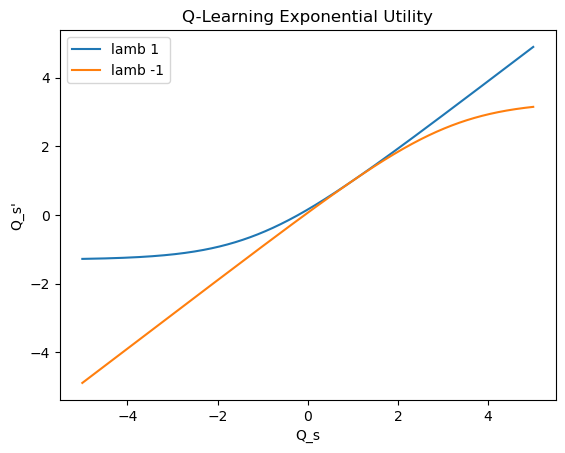

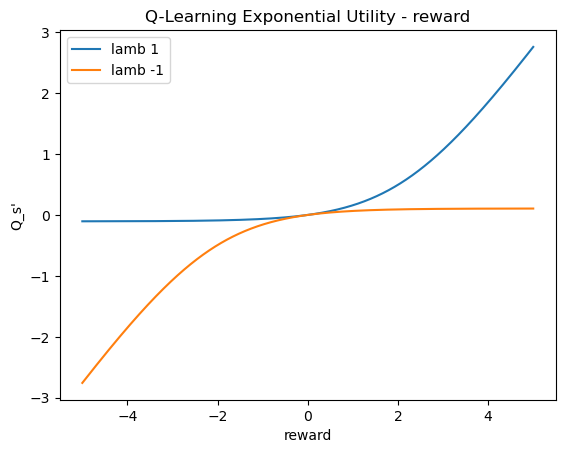

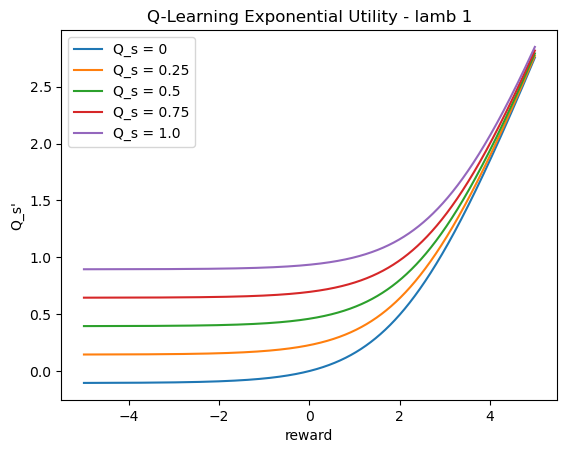

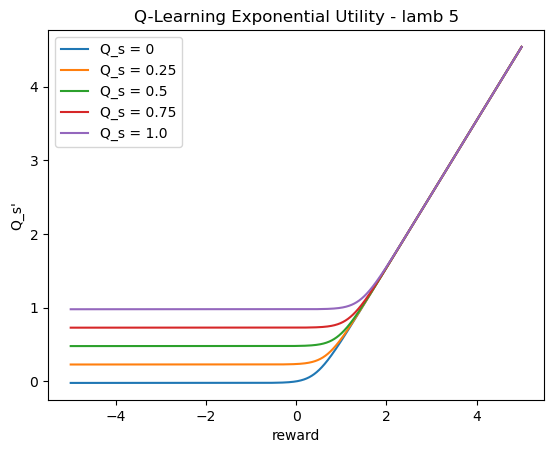

In [257]:
def utility(lamb, x):
        return np.sign(lamb) * math.exp(lamb * x)
    
def reverse_utility(lamb, x):
        return math.log(np.sign(lamb) * x) / lamb  
    
def func_LogSumEXP(q_curr, q_next, alpha, gamma, lamb, reward):
    
    target = reward + (gamma * q_next)
    u = utility(lamb, target)
    u_q = utility(lamb, q_curr)
    return reverse_utility(lamb, u_q + (alpha * (u - u_q)))

def func_LogSumEXP_curr(x, q_next, alpha, gamma, lamb, reward):
    result = []
    for i in x:
        result.append(func_LogSumEXP(i,q_next,alpha,gamma, lamb, reward)) 
    return result

def func_LogSumEXP_reward(q_curr, q_next, alpha, gamma, lamb, x):
    result = []
    for i in x:
        result.append(func_LogSumEXP(q_curr,q_next,alpha,gamma, lamb, i)) 
    return result


x = np.linspace(-5, 5, 100000)


q_next=0
reward = 1
plt.plot(x, func_LogSumEXP_curr(x,q_next,alpha,gamma, 1, reward), label='lamb 1');
plt.plot(x, func_LogSumEXP_curr(x,q_next,alpha,gamma, -1, reward), label='lamb -1');
plt.legend()
plt.title('Q-Learning Exponential Utility')
plt.xlabel('Q_s')
plt.ylabel('Q_s\'')
plt.show()



q_next=0
q_curr=0
reward = 1
plt.plot(x, func_LogSumEXP_reward(q_next,q_next,alpha,gamma, 1, x), label='lamb 1');
plt.plot(x, func_LogSumEXP_reward(q_next,q_next,alpha,gamma, -1, x), label='lamb -1');
plt.legend()
plt.title('Q-Learning Exponential Utility - reward')
plt.xlabel('reward')
plt.ylabel('Q_s\'')
plt.show()



reward = 1

for q_curr in [0,0.25,0.5,0.75,1.0]:
    plt.plot(x, func_LogSumEXP_reward(q_curr,q_next,alpha,gamma, 1, x), label='Q_s = {}'.format(q_curr));

plt.legend()
plt.title('Q-Learning Exponential Utility - lamb 1')
plt.xlabel('reward')
plt.ylabel('Q_s\'')
plt.show()

for q_curr in [0,0.25,0.5,0.75,1.0]:
    plt.plot(x, func_LogSumEXP_reward(q_curr,q_next,alpha,gamma, 5, x), label='Q_s = {}'.format(q_curr));

plt.legend()
plt.title('Q-Learning Exponential Utility - lamb 5')
plt.xlabel('reward')
plt.ylabel('Q_s\'')
plt.show()

In [230]:
for i in range(0, 31):
    arm_0_r = (-1.0 + (i * (2 / 30)))
    print(arm_0_r)

-1.0
-0.9333333333333333
-0.8666666666666667
-0.8
-0.7333333333333334
-0.6666666666666667
-0.6
-0.5333333333333333
-0.4666666666666667
-0.4
-0.33333333333333337
-0.2666666666666667
-0.19999999999999996
-0.1333333333333333
-0.06666666666666665
0.0
0.06666666666666665
0.1333333333333333
0.19999999999999996
0.2666666666666666
0.33333333333333326
0.3999999999999999
0.46666666666666656
0.5333333333333332
0.6000000000000001
0.6666666666666667
0.7333333333333334
0.8
0.8666666666666667
0.9333333333333333
1.0


In [266]:
math.exp(0)

1.0